# TP3

In [315]:
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.signal import welch
import scipy as sp
import pandas as pd
import seaborn
import numpy as np
from matplotlib.colors import LogNorm
import math
import itertools
import sklearn.metrics
from sklearn.metrics import auc
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.datasets import samples_generator
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

%matplotlib inline

Samples = 201
Duration = 0.8

DELTA = (0,4)
THETA = (4,8)
ALPHA = (8,13)
BETA = (13,30)
GAMMA = (30,45) 

electrodes = [4,12,13,14,19,20,21,22,25,26,27,28,29,31,32,33,34,35]

In [2]:
cant_electrodes = len(electrodes)

### Sujetos

In [3]:
SUJETOS_P = ["/Users/lmatayoshi/Desktop/EEG/P" + str(0) + str(i) + ".mat" for i in range(1,10)]
SUJETOS_P.append("/Users/lmatayoshi/Desktop/EEG/P10.mat")

SUJETOS_S = ["/Users/lmatayoshi/Desktop/EEG/S" + str(0) + str(i) + ".mat" for i in range(1,10)]
SUJETOS_S.append("/Users/lmatayoshi/Desktop/EEG/S10.mat")

In [4]:
def banda_frecuencia_groups(electrodes):
    frecuencias_mean_S = []
    frecuencias_mean_P = []
    frecuencias_std_P = []
    frecuencias_std_S = []
    for sujeto_S in SUJETOS_S:
        bandas_df_mean,bandas_df_sd = bandas_frecuencia_sujeto(sujeto_S,electrodes)
        frecuencias_mean_S.append(bandas_df_mean)
        frecuencias_std_S.append(bandas_df_sd)
    for sujeto_P in SUJETOS_P:
        bandas_df_mean,bandas_df_sd = bandas_frecuencia_sujeto(sujeto_P,electrodes)
        frecuencias_mean_P.append(bandas_df_mean)
        frecuencias_std_P.append(bandas_df_sd)    
    return frecuencias_mean_S, frecuencias_std_S, frecuencias_mean_P, frecuencias_std_P

def bandas_frecuencia_sujeto(sujeto,electrodes): 
    """
    Esta función se realizo para gráficar las bandas de frecuencia para un solo sujeto (con fines de economizar tiempo)
    """
    
    sujeto_matrix = sio.loadmat(sujeto)
    sujeto_matrix = sujeto_matrix['data']
    mean_electrodos = np.mean(sujeto_matrix[:,electrodes,:], axis=1) # Promedio de todos los electrodos
    
    f, Pxx = welch(mean_electrodos, float(Samples/Duration), nfft=1025) # Realizo un welch por epoca

    xs = []
    for i in [DELTA[1],THETA[1],ALPHA[1],BETA[1],GAMMA[1]]:
        for j in range(0,len(f)):
            if(f[j]>i):
                xs.append(j);
                break;
    # hicimos la banda de frecuencia promedidada por cada epoch
    
    epochs_x_banda=np.zeros((Pxx.shape[0], 5))
    for epoch in range(0, Pxx.shape[0]):
        delta_epoch = np.mean(Pxx[epoch][0:xs[0]])
        theta_epoch = np.mean(Pxx[epoch][xs[0]:xs[1]])
        alpha_epoch = np.mean(Pxx[epoch][xs[1]:xs[2]])
        beta_epoch = np.mean(Pxx[epoch][xs[2]:xs[3]])
        gamma_epoch = np.mean(Pxx[epoch][xs[3]:])
        epochs_x_banda[epoch] = np.array([delta_epoch, theta_epoch, alpha_epoch, beta_epoch, gamma_epoch])
                
    todas = np.mean(epochs_x_banda, axis=0)
    todis = np.std(epochs_x_banda, axis=0)

    
    #print todas.shape   
    #electrodes_power_mean = np.mean(Pxx, axis=0) 
    
    # Se promedian las potencias de todas las epocas, se obtiene
    # de esta manera, un valor de potencia promedio para cada frecuencia
    
    
    bandas_df_mean = pd.DataFrame(todas, index=["Delta", "Theta", "Alpha", "Beta", "Gamma"])
    bandas_df_sd = pd.DataFrame (todis, index=["Delta_SD", "Theta_SD", "Alpha_SD", "Beta_SD", "Gamma_SD"])
    #bandas_power = ([Delta, Theta, Alpha, Beta, Gamma],[Delta_SD, Theta_SD, Alpha_SD, Beta_SD, Gamma_SD])
    return todas,todis

In [6]:
frecuencias_mean_S, frecuencias_std_S, frecuencias_mean_P, frecuencias_std_P = banda_frecuencia_groups(electrodes)

# Normalizacion

In [7]:
def bandas_normalizadas_groups(electrodes):
    frecuencias_mean_S = []
    frecuencias_mean_P = []
    frecuencias_std_P = []
    frecuencias_std_S = []
    for sujeto_S in SUJETOS_S:
        bandas_df_mean,bandas_df_sd = bandas_frecuencia_normalizadas_sujeto(sujeto_S,electrodes)
        frecuencias_mean_S.append(bandas_df_mean)
        frecuencias_std_S.append(bandas_df_sd)
    for sujeto_P in SUJETOS_P:
        bandas_df_mean,bandas_df_sd = bandas_frecuencia_normalizadas_sujeto(sujeto_P,electrodes)
        frecuencias_mean_P.append(bandas_df_mean)
        frecuencias_std_P.append(bandas_df_sd)    
    return frecuencias_mean_S, frecuencias_std_S, frecuencias_mean_P, frecuencias_std_P

def bandas_frecuencia_normalizadas_sujeto(sujeto,electrodes): 
    """
    Esta función se realizo para gráficar las bandas de frecuencia para un solo sujeto (con fines de economizar tiempo)
    En caso de de ser necesario puede agrandarse a varios sujetos,  ver 2.e 
    """
    
    sujeto_matrix = sio.loadmat(sujeto)
    sujeto_matrix = sujeto_matrix['data']
    mean_electrodos = np.mean(sujeto_matrix[:,electrodes,:], axis=1) # Promedio de todos los electrodos
    
    f, Pxx = welch(mean_electrodos, float(Samples/Duration), nfft=1025) # Realizo un welch por epoca

    xs = []
    for i in [DELTA[1],THETA[1],ALPHA[1],BETA[1],GAMMA[1]]:
        for j in range(0,len(f)):
            if(f[j]>i):
                xs.append(j);
                break;
    #·hicimos la banda de frecuencia promedidada por cada epoch
    
    
    epochs_x_banda=np.zeros((Pxx.shape[0], 5))
    for epoch in range(0, Pxx.shape[0]):
        valor_de_normalizacion = 1/sum(Pxx[epoch][0:GAMMA[1]])

        delta_epoch = np.mean(Pxx[epoch][0:xs[0]])*valor_de_normalizacion
        theta_epoch = np.mean(Pxx[epoch][xs[0]:xs[1]])*valor_de_normalizacion
        alpha_epoch = np.mean(Pxx[epoch][xs[1]:xs[2]])*valor_de_normalizacion
        beta_epoch = np.mean(Pxx[epoch][xs[2]:xs[3]])*valor_de_normalizacion
        gamma_epoch = np.mean(Pxx[epoch][xs[3]:])*valor_de_normalizacion
        
        epochs_x_banda[epoch] = np.array([delta_epoch, theta_epoch, alpha_epoch, beta_epoch, gamma_epoch])
                
    all_means = np.mean(epochs_x_banda, axis=0)
    all_stds = np.std(epochs_x_banda, axis=0)

    
    #print todas.shape
    
    
    #electrodes_power_mean = np.mean(Pxx, axis=0) # Se promedian las potencias de todas las epocas, se obtiene
                                                 # de esta manera, un valor de potencia promedio para cada frec
    
    
    bandas_df_mean = pd.DataFrame(all_means, index=["Delta", "Theta", "Alpha", "Beta", "Gamma"])
    bandas_df_sd = pd.DataFrame (all_stds, index=["Delta_SD", "Theta_SD", "Alpha_SD", "Beta_SD", "Gamma_SD"])
    #bandas_power = ([Delta, Theta, Alpha, Beta, Gamma],[Delta_SD, Theta_SD, Alpha_SD, Beta_SD, Gamma_SD])
    return all_means, all_stds

In [8]:
frecuencias_mean_S_normalizadas, frecuencias_std_S_normalizadas, frecuencias_mean_P_normalizadas, frecuencias_std_P_normalizadas = bandas_normalizadas_groups(electrodes)

# 2.1 Analisis Univariado

Para cada feature, computar la curva ROC y graficarla

## Entropia intraelectrodo

In [31]:
def calculate_bin_max_min(matrix_sujeto):
    cant_electrodos = matrix_sujeto.shape[1]
    x25 = np.zeros(cant_electrodos)
    x75 = np.zeros(cant_electrodos)
    maximum = np.zeros(cant_electrodos)
    minimum = np.zeros(cant_electrodos)
    
    for i in range(0,cant_electrodos):
        electrodo_actual = np.copy(matrix_sujeto[:, i, :])
        np.sort(electrodo_actual, axis=None)

        maximum[i] = electrodo_actual.max()
        minimum[i] = electrodo_actual.min()
        x75[i] = np.percentile(electrodo_actual, 75)
        x25[i] = np.percentile(electrodo_actual, 25)
        
    return np.max(maximum), np.min(minimum), np.mean(x75), np.mean(x25)

In [32]:
def calculate_tbin(maximum, minimum, x75, x25, matrix_shape):
    n_instances = matrix_shape[0] * matrix_shape[2]
    return 2 * (x75-x25) / (math.pow(n_instances,1.0/3))

In [33]:
# numpy arange step
def calculate_probabilities(electrodo_matrix, max_val, min_val, t_bin):
    bins = np.arange(min_val, max_val, t_bin)
    acum = np.zeros(bins.shape[0] - 1)
    for i in range(0, electrodo_matrix.shape[0]):
        hist, _ = np.histogram(electrodo_matrix[i,:], bins=bins)
        acum = acum + hist
    return (acum / float(electrodo_matrix.shape[0] * electrodo_matrix.shape[1]))

In [34]:
def calculate_entropia(proba_x, cant_epochs, cant_muestras):
    res=0
    for i in range(0,len(proba_x)):
        if proba_x[i] > 0:
            res = res + (proba_x[i]/(cant_epochs*cant_muestras))*math.log((proba_x[i]/(cant_epochs*cant_muestras)),10)
    return -res

In [35]:
def entropias_electrodos_por_sujeto(filename):
    sujeto = sio.loadmat(filename)
    matrix_sujeto = sujeto['data']
    cant_epochs = matrix_sujeto.shape[0]
    #cant_electrodos = matrix_sujeto.shape[1]
    cant_muestras = matrix_sujeto.shape[2] 
    
    max_value, min_value, x75, x25 = calculate_bin_max_min(matrix_sujeto)
    t_bin = calculate_tbin(max_value, min_value, x75, x25, matrix_sujeto.shape)
    
    global electrodes

    entropia_por_electrodo = []
    for i in electrodes:
        electrodo_i_matrix = matrix_sujeto[:, i, :]
        #t_bin = calculate_tbin(maximum_values[i], minimum_values[i], x75_values[i], x25_values[i])
        probabilities = calculate_probabilities(electrodo_i_matrix, max_value, min_value, t_bin)
        entropia_por_electrodo.append(calculate_entropia(probabilities, cant_epochs, cant_muestras))
    return entropia_por_electrodo

In [36]:
def calculate_entropias_group():
    entropias_group_mean = np.zeros((2,10))
    entropias_group_std = np.zeros((2,10))
    for i in range(0,len(SUJETOS_S)):
        res_P = entropias_electrodos_por_sujeto(SUJETOS_P[i])
        entropias_group_mean[1][i]=np.mean(res_P)
        entropias_group_std[1][i]=np.std(res_P)
        res_S = entropias_electrodos_por_sujeto(SUJETOS_S[i])
        entropias_group_mean[0][i]=np.mean(res_S)
        entropias_group_std[0][i]=np.std(res_S)
    return entropias_group_mean, entropias_group_std

In [15]:
entropias_group_mean, entropias_group_std = calculate_entropias_group() 

In [16]:
ent_gr_mean = np.ndarray.tolist(entropias_group_mean)
flat_list = [item for sublist in ent_gr_mean for item in sublist]
ent_gr_mean = np.array(flat_list)
ent_gr_mean.shape

(20,)

In [17]:
ent_gr_std = np.ndarray.tolist(entropias_group_std)
flat_list = [item for sublist in ent_gr_std for item in sublist]
ent_gr_std = np.array(flat_list)
ent_gr_std.shape

(20,)

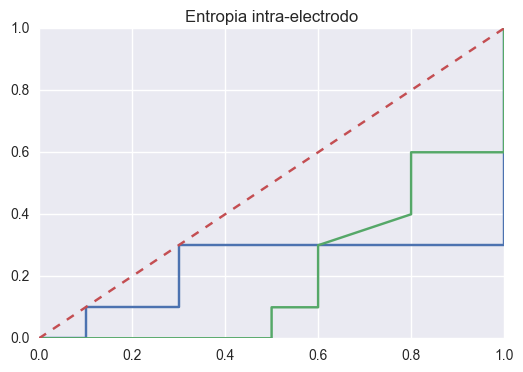

In [310]:
# Curva ROC con promedio y STD para la entropia intra-electrodo
labels = [1] * 10 + [0] * 10
values = np.concatenate((entropias_group_mean[1], entropias_group_mean[0]))
values_std = np.concatenate((entropias_group_std[1], entropias_group_std[0]))
fpr, tpr, a = sklearn.metrics.roc_curve(labels, values)
fpr_std, tpr_std, a_std = sklearn.metrics.roc_curve(labels, values_std)
xs = np.linspace(0, 1, 10)
plt.plot(fpr, tpr)
plt.plot(fpr_std, tpr_std)
plt.plot(xs, xs, linestyle="--")
plt.title("Entropia intra-electrodo")
plt.show()

# Entropia conjunta  Interelectrodo

In [38]:
def calculate_serie(electrodo_matrix, electrodo_serie, min_val, t_bin, cant_bins):
    tam_fila = electrodo_matrix.shape[0] #cant_epochs
    tam_columna = electrodo_matrix.shape[1] #cant_muestras

    vec = np.zeros(cant_bins)
    a = 0
    
    for i in range(0,tam_fila):
        for j in range(0,tam_columna):
            bin_index = int((electrodo_matrix[i][j]-min_val)/t_bin)
            vec[bin_index]=vec[bin_index]+1
            electrodo_serie[i][j] = ord('A')+bin_index
            a=a+1

In [39]:
def probabilidad_conjunta(matrix_serie_1,matrix_serie_2, cant_bins):
    
    mat_PConjunta = np.zeros((cant_bins,cant_bins))

    tam_fila_serie = matrix_serie_1.shape[0]
    tam_columna_serie = matrix_serie_1.shape[1]

    size_serie = tam_fila_serie*tam_columna_serie
    
    for i in range(0,tam_fila_serie):
        for j in range(0,tam_columna_serie):
            index_f = int(matrix_serie_1[i][j]-ord('A'))
            index_c = int(matrix_serie_2[i][j]-ord('A'))
            mat_PConjunta[index_f][index_c]=mat_PConjunta[index_f][index_c]+1
            
    for i in range(0,cant_bins):
        for j in range(0,cant_bins):
            mat_PConjunta[i][j]=mat_PConjunta[i][j]/size_serie
            
    return mat_PConjunta

In [40]:
def calculate_entropia_conjunta(matrix_serie_1,matrix_serie_2,cant_bins):

    mat_PConjunta = probabilidad_conjunta(matrix_serie_1,matrix_serie_2,cant_bins)
    
    res=0
    for h in range(0,mat_PConjunta.shape[0]):
        for k in range(0,mat_PConjunta.shape[1]):
            if(mat_PConjunta[h][k]!=0):
                res=res+(mat_PConjunta[h][k])*math.log(mat_PConjunta[h][k])
    return -res

Se realizò un recorte de los 256 electrodos para el càlculo de la entropìa interelectrodo. Se seleccionaron cuatro cluster correspondientes a la regiòn pre-frontal, debido a su relevancìa en el procesamiento conciente(Dehaene & Changeux, 2011)

In [41]:
electrodes_grupo_1 = [31, 32, 35]
electrodes_grupo_2 = [33, 26, 19, 27, 21, 20]
electrodes_grupo_3 = [34, 28, 29, 22]
electrodes_grupo_4 = [12, 13, 14, 4, 5]

In [25]:
electrode_groups = [electrodes_grupo_1, electrodes_grupo_2, electrodes_grupo_3, electrodes_grupo_4]

## Datos de entropia conjunta

In [42]:
entropia_conjunta_mean_P = [
    8.88586848583,
    8.65413612925,
    8.78117154693,
    9.3492405686,
    8.67933809549,
    9.11941950404,
    8.91359472144,
    9.0386464701,
    8.10123432253,
    8.83650914978
]

entropia_conjunta_mean_S = [
    8.12147605043,
    7.26826102141,
    8.54137842366,
    8.5153131522,
    8.20354011649,
    8.05144226961,
    8.62693780823,
    8.37295069848,
    8.57618979548,
    8.64700389018
]
entropia_conjunta_mean = np.array(entropia_conjunta_mean_S + entropia_conjunta_mean_P)

In [43]:
entropia_conjunta_std_P = [
    0.193741863889,
    0.219379895889,
    0.287414914788,
    0.152947435212,
    0.406198111093,
    0.192747024669,
    0.217592507868,
    0.283456520592,
    0.147790599355,
    0.182857156466
]

entropia_conjunta_std_S = [
    0.408182971943,
    0.221059202073,
    0.206236358566,
    0.172495249745,
    0.196259683607,
    0.103636808734,
    0.135664770592,
    0.237231956055,
    0.215413931689,
    0.139311006346
]
entropia_conjunta_std = np.array(entropia_conjunta_std_S + entropia_conjunta_std_P)

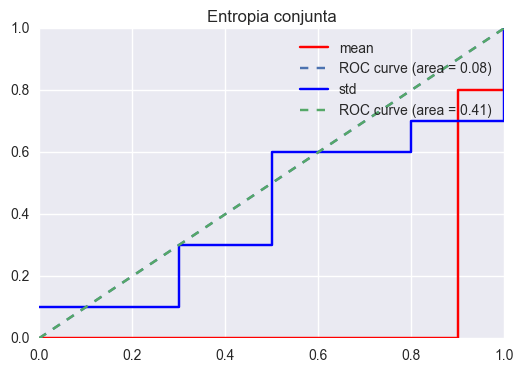

In [44]:
curva_roc_unificada(labels, entropia_conjunta_mean, entropia_conjunta_std, "Entropia conjunta")

In [25]:
def curva_roc(labels, feature_values, label):
    if label=="mean":
        color = "red"
    else:
        color = "blue"
    feature_values = feature_values.reshape(-1, 1) #Se escalaron los valores, debido a que los Pxx en las bandas eran 
    scaler = StandardScaler()                      # demasiados pequeños.
    feature_values =  scaler.fit_transform(feature_values)
    fpr, tpr, a = sklearn.metrics.roc_curve(labels, feature_values)
    roc_area = auc(fpr, tpr)
    #print feature_values
    plt.plot(fpr, tpr, label=label, color=color)
    xs = np.linspace(0, 1, 10)
    
    plt.plot(xs, xs, linestyle="--", label = 'ROC curve (area = %0.2f)' % roc_area)
    plt.legend()

def curva_roc_unificada(labels, feature_mean , feature_std , title):
    curva_roc(labels, feature_mean, "mean")
    curva_roc(labels, feature_std, "std")
    plt.title(str(title))
    plt.show()
    
#def curva_roc_logistic(labels, logistic_regression):
#    curva_roc(labels, logistic_regression)
#    plt.show()

In [ ]:
# frecuencias_mean_S, frecuencias_std_S, frecuencias_mean_P, frecuencias_std_P

In [33]:
labels = [1] * 10 + [0] * 10

In [46]:
frecuencias_mean_S = np.array(frecuencias_mean_S)
frecuencias_mean_P = np.array(frecuencias_mean_P)
frecuencias_std_S = np.array(frecuencias_std_S)
frecuencias_std_P = np.array(frecuencias_std_P)
frecuencias_mean_S_normalizada = np.array(frecuencias_mean_S_normalizadas)
frecuencias_mean_P_normalizada = np.array(frecuencias_mean_P_normalizadas)
frecuencias_std_S_normalizada = np.array(frecuencias_std_S_normalizadas)
frecuencias_std_P_normalizada = np.array(frecuencias_std_P_normalizadas)

### Curvas ROC para todas las bandas de frecuencia

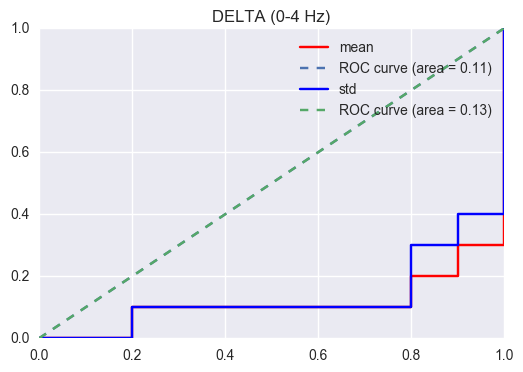

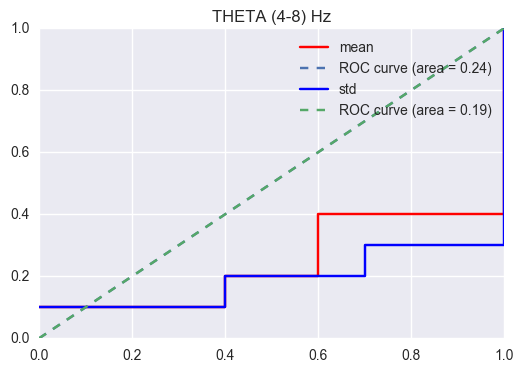

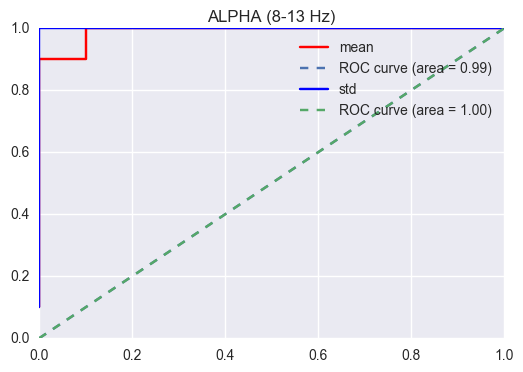

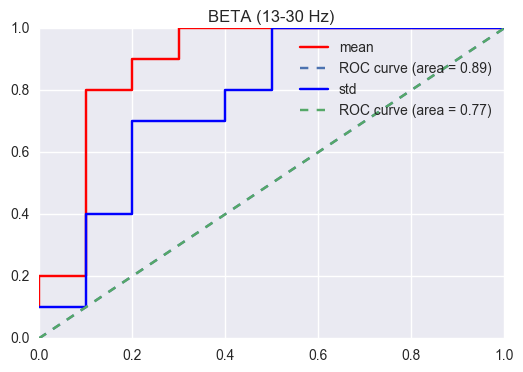

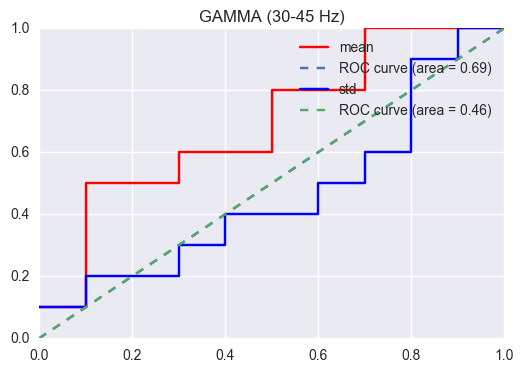

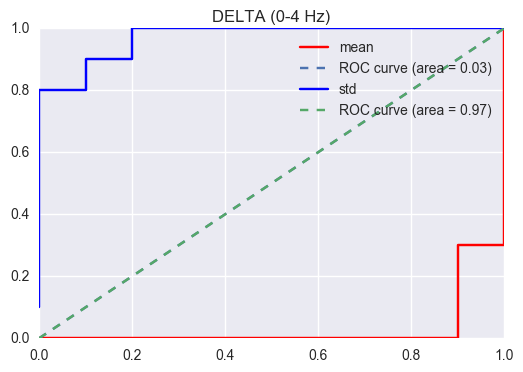

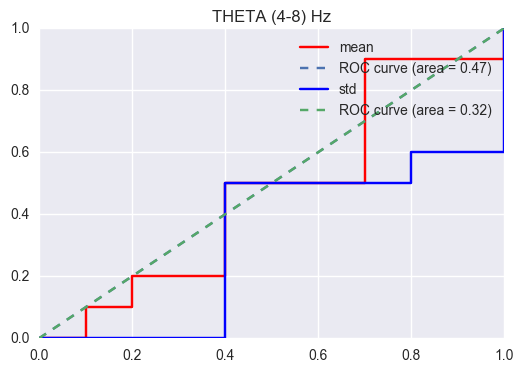

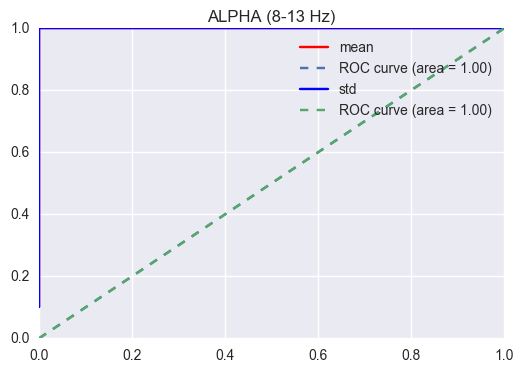

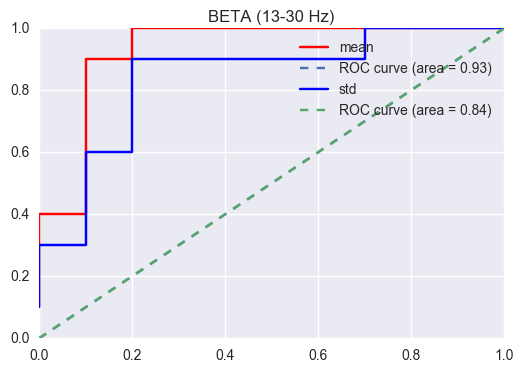

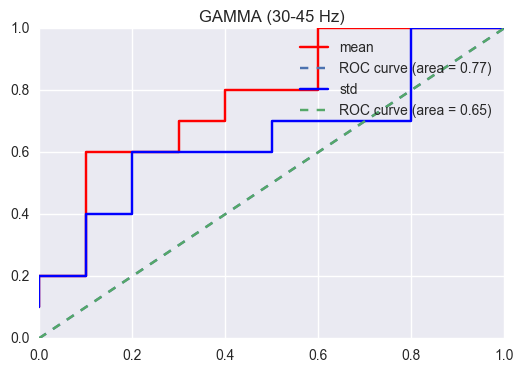

In [47]:
# Primero gráficamos las curvas ROC para los valores no normalizados

# curva roc DELTA = (0,4)
curva_roc_unificada(labels, np.concatenate((frecuencias_mean_S[:,0], frecuencias_mean_P[:,0])),np.concatenate((frecuencias_std_S[:,0], frecuencias_std_P[:,0])),"DELTA (0-4 Hz)")
# curva roc THETA = (4,8)
curva_roc_unificada(labels, np.concatenate((frecuencias_mean_S[:,1], frecuencias_mean_P[:,1])), np.concatenate((frecuencias_std_S[:,1], frecuencias_std_P[:,1])),"THETA (4-8) Hz")
# curva roc ALPHA = (8,13)
curva_roc_unificada(labels, np.concatenate((frecuencias_mean_S[:,2], frecuencias_mean_P[:,2])), np.concatenate((frecuencias_std_S[:,2], frecuencias_std_P[:,2])),"ALPHA (8-13 Hz)")
# curva roc BETA = (13,30)
curva_roc_unificada(labels, np.concatenate((frecuencias_mean_S[:,3], frecuencias_mean_P[:,3])), np.concatenate((frecuencias_std_S[:,3], frecuencias_std_P[:,3])),"BETA (13-30 Hz)")
# curva roc GAMMA = (30,45) 
curva_roc_unificada(labels, np.concatenate((frecuencias_mean_S[:,4], frecuencias_mean_P[:,4])), np.concatenate((frecuencias_std_S[:,4], frecuencias_std_P[:,4])),"GAMMA (30-45 Hz)")

#Finalmente gráficamos los valores de las bandas de frecuencia normalizadas
curva_roc_unificada(labels, np.concatenate((frecuencias_mean_S_normalizada[:,0], frecuencias_mean_P_normalizada[:,0])), np.concatenate((frecuencias_std_S_normalizada[:,0], frecuencias_std_P_normalizada[:,0])),"DELTA (0-4 Hz)")
curva_roc_unificada(labels, np.concatenate((frecuencias_mean_S_normalizada[:,1], frecuencias_mean_P_normalizada[:,1])), np.concatenate((frecuencias_std_S_normalizada[:,1], frecuencias_std_P_normalizada[:,1])),"THETA (4-8) Hz")
curva_roc_unificada(labels, np.concatenate((frecuencias_mean_S_normalizada[:,2], frecuencias_mean_P_normalizada[:,2])), np.concatenate((frecuencias_std_S_normalizada[:,2], frecuencias_std_P_normalizada[:,2])),"ALPHA (8-13 Hz)")
curva_roc_unificada(labels, np.concatenate((frecuencias_mean_S_normalizada[:,3], frecuencias_mean_P_normalizada[:,3])), np.concatenate((frecuencias_std_S_normalizada[:,3], frecuencias_std_P_normalizada[:,3])),"BETA (13-30 Hz)")
curva_roc_unificada(labels, np.concatenate((frecuencias_mean_S_normalizada[:,4], frecuencias_mean_P_normalizada[:,4])), np.concatenate((frecuencias_std_S_normalizada[:,4], frecuencias_std_P_normalizada[:,4])),"GAMMA (30-45 Hz)")


## 2.b 
Utilizando una técnica de cross validación, estimar la performance de un classificador Logistic Regression para cada feature y graficar la curva ROC correspondiente. ¿Cuál es su conclución respecto a los resultados obtenidos en el punto anterior?

### Clasificador - Logistic Regression

In [36]:
def logistic_regresion_f(frec_mean_S,frec_mean_P):
    training_instances = np.concatenate((frec_mean_S, frec_mean_P))
    training_instances = training_instances.reshape(-1, 1) # Se escalaron los valores, debido a que los Pxx en las bandas eran 
    scaler = StandardScaler()                              # demasiados pequeños.
    training_instances =  scaler.fit_transform(training_instances)
    logistic = linear_model.LogisticRegression()
    labels = [1] * 7 + [0] * 7 
    #test_instances = np.concatenate((frec_mean_S_test, frec_mean_P_test))
    logistic.fit(list(training_instances.reshape(-1,1)), labels)
    return logistic

In [37]:
 # Se tomo como set de entrenamiento 14 sujetos (7 de cada grupo) y estableciendo un set de test de 6 miembros (3 S y 3 P)
logistic_mean = []
logistic_std = []
logistic_mean_norm = []
logistic_std_norm = []
for i in range(0,5):
    logistic_mean.append(logistic_regresion_f(frecuencias_mean_S[:7,0],frecuencias_mean_P[:7,i]))
    logistic_std.append(logistic_regresion_f(frecuencias_std_S[:7,i],frecuencias_std_P[:7,i]))
for i in range(0,5):
    logistic_mean_norm.append(logistic_regresion_f(frecuencias_mean_S_normalizada[:7,i],frecuencias_mean_P_normalizada[:7,i]))
    logistic_std_norm.append(logistic_regresion_f(frecuencias_std_S_normalizada[:7,i],frecuencias_std_P_normalizada[:7,i]))

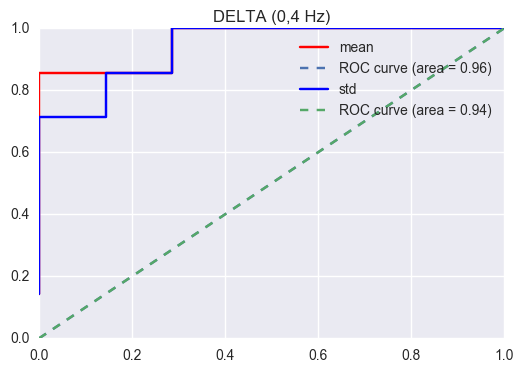

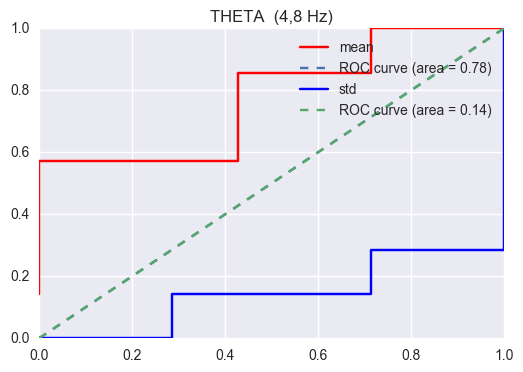

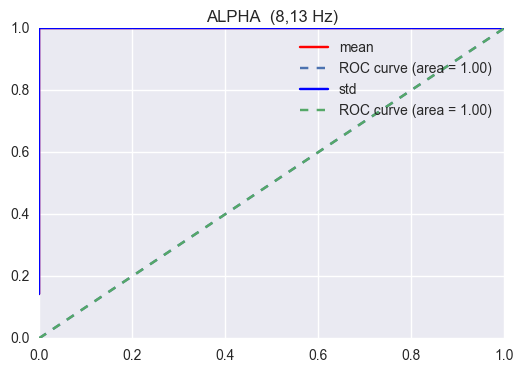

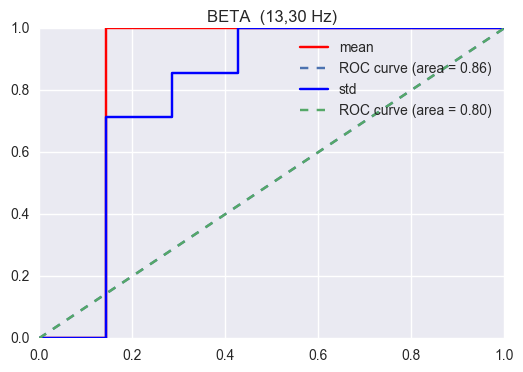

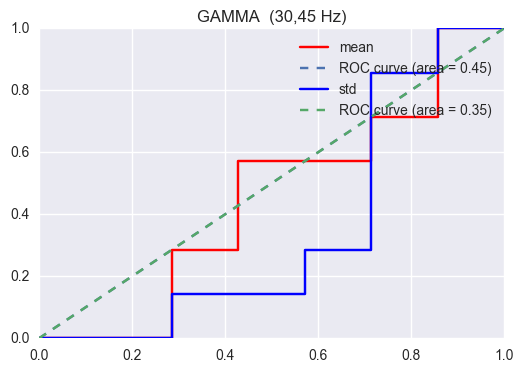

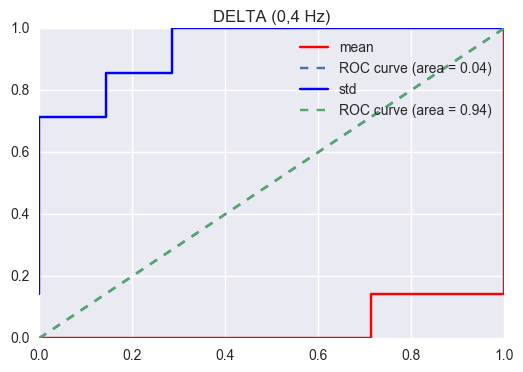

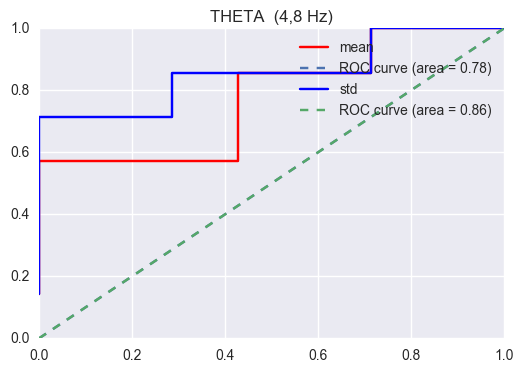

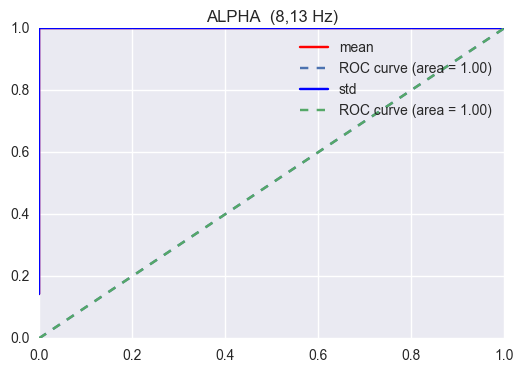

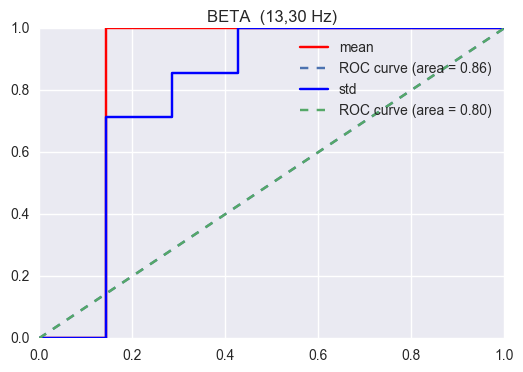

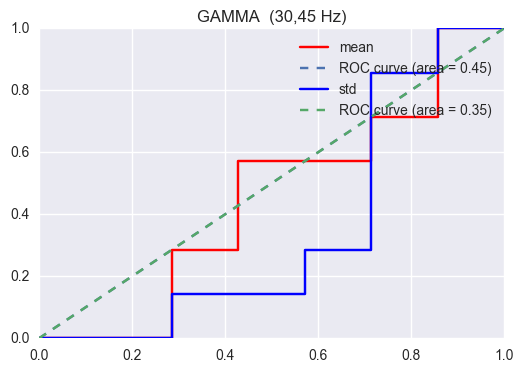

In [40]:
logistic_regresion_graphs(logistic_mean,logistic_std)
logistic_regresion_graphs(logistic_mean_norm,logistic_std_norm)

In [312]:
title = ["DELTA (0,4 Hz)","THETA  (4,8 Hz)","ALPHA  (8,13 Hz)","BETA  (13,30 Hz)","GAMMA  (30,45 Hz)"]
def logistic_regresion_graphs(logistic_std,logistic_mean):
    for i in range(0,5):   
        banda_frec_regression_std = logistic_std[i]
        banda_frec_regression_mean = logistic_mean[i]

        test_instances_std = np.array(np.concatenate((frecuencias_std_S[:7, i], frecuencias_std_P[:7,i])))
        test_instances_std = test_instances_std.reshape(-1,1)
        test_instances_mean = np.array(np.concatenate((frecuencias_mean_S[:7, i], frecuencias_mean_P[:7,i])))
        test_instances_mean = test_instances_mean.reshape(-1,1)

        scaler = StandardScaler() 
        test_instances_std = scaler.fit_transform(test_instances_std)
        test_instances_mean = scaler.fit_transform(test_instances_mean)

        results_std = banda_frec_regression_std.predict_proba(test_instances_std)[:, 1]
        results_mean = banda_frec_regression_mean.predict_proba(test_instances_mean)[:, 1]

        curva_roc_unificada( [1] * 7 + [0] * 7, results_mean, results_std,title[i])
        plt.show()

## Cross Validation

In [548]:
def cross_validation(X, Y, n_folds):
    kf = KFold(Y.shape[0], n_folds=n_folds, shuffle=True)
    results = []
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        scaler = StandardScaler()
        X_train =  scaler.fit_transform(X_train.reshape(-1,1))
        X_test = scaler.fit_transform(X_test.reshape(-1,1))
        logistic = linear_model.LogisticRegression()
        logistic.fit(X_train.reshape(-1,1), y_train)
        probabilities = logistic.predict_proba(X_test.reshape(-1,1))
        results.append(probabilities)
    results = np.mean(np.array(results), axis=0)
    curva_roc(y_test, results[:,1], "Cross validation folds= " + str(n_folds))
    plt.show()

Método de cross validation para el mean de la banda DELTA para n_folds = 4

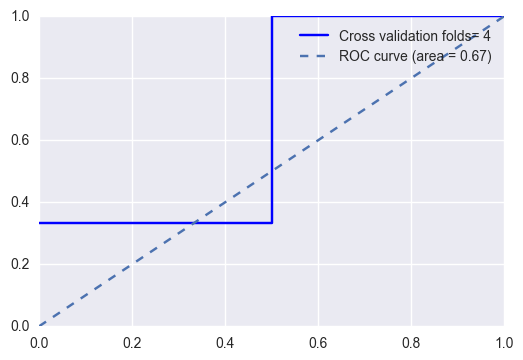

In [550]:
X = np.concatenate((frecuencias_mean_S[:,0], frecuencias_mean_P[:,0]))
Y = np.array(labels)
cross_validation(X, Y, 4)

Método de cross validation para el mean de la banda ALPHA para n_folds = 4

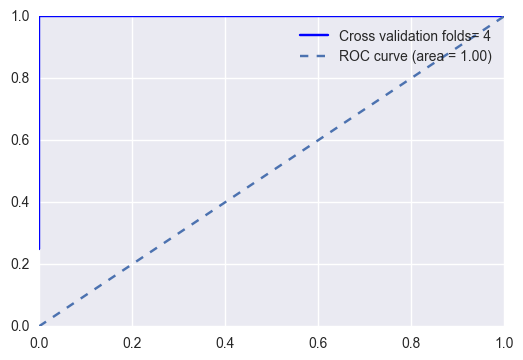

In [549]:
X = np.concatenate((frecuencias_mean_S[:,2], frecuencias_mean_P[:,2]))
Y = np.array(labels)
cross_validation(X, Y, 4)

Luego de computar la curva ROC para cada feature y aplicar la tecnica de cross validation pudimos observar, que la tendencia de la variacion en las curvas es similar dado que estamos graficando un conjunto y un subconjunto de el. Consideramos que al utilizar menos instancias para entrenar al clasificador de Logistic regression existen esas diferencias. Pero si utilizaramos el mismo conjunto las curvas serian iguales. En ambas modalidades se destaca la eficaciaa del feture "Banda de frecuencia en Alpha", como el feature que mejor permite clasificar entre los grupos S y P. 

## 2.2 Análisis Multivariado

a) Utilizar todos los features y entrenar un clasificador basado en Support Vector Machine. Computar la curva roc y graficarla. No olvidar reportar el area bajo la curva.
Los features estaran ordenados: Delta a Gamma Mean, Delta a Gamma Mean Normalized, Delta a Gamma STD,Delta a Gamma STD Normalized, Entropia intra Mean ,Entropia intra STD, Entropia inter Mean, Entropia inter STD

In [50]:
all_instances = np.array([
    np.concatenate((frecuencias_mean_S[:,0], frecuencias_mean_P[:,0])),
    np.concatenate((frecuencias_mean_S[:,1], frecuencias_mean_P[:,1])), 
    np.concatenate((frecuencias_mean_S[:,2], frecuencias_mean_P[:,2])), 
    np.concatenate((frecuencias_mean_S[:,3], frecuencias_mean_P[:,3])),  
    np.concatenate((frecuencias_mean_S[:,4], frecuencias_mean_P[:,4])), 

    np.concatenate((frecuencias_mean_S_normalizada[:,0], frecuencias_mean_P_normalizada[:,0])),
    np.concatenate((frecuencias_mean_S_normalizada[:,1], frecuencias_mean_P_normalizada[:,1])),
    np.concatenate((frecuencias_mean_S_normalizada[:,2], frecuencias_mean_P_normalizada[:,2])),
    np.concatenate((frecuencias_mean_S_normalizada[:,3], frecuencias_mean_P_normalizada[:,3])),
    np.concatenate((frecuencias_mean_S_normalizada[:,4], frecuencias_mean_P_normalizada[:,4])), 

    np.concatenate((frecuencias_std_S[:,0], frecuencias_std_P[:,0])),
    np.concatenate((frecuencias_std_S[:,1], frecuencias_std_P[:,1])),
    np.concatenate((frecuencias_std_S[:,2], frecuencias_std_P[:,2])),
    np.concatenate((frecuencias_std_S[:,3], frecuencias_std_P[:,3])),
    np.concatenate((frecuencias_std_S[:,4], frecuencias_std_P[:,4])),
    np.concatenate((frecuencias_std_S_normalizada[:,0], frecuencias_std_P_normalizada[:,0])),
    np.concatenate((frecuencias_std_S_normalizada[:,1], frecuencias_std_P_normalizada[:,1])),
    np.concatenate((frecuencias_std_S_normalizada[:,2], frecuencias_std_P_normalizada[:,2])),
    np.concatenate((frecuencias_std_S_normalizada[:,3], frecuencias_std_P_normalizada[:,3])),
    np.concatenate((frecuencias_std_S_normalizada[:,4], frecuencias_std_P_normalizada[:,4])),
    ent_gr_mean,
    ent_gr_std,
    entropia_conjunta_mean,
    entropia_conjunta_std  
]
)


In [589]:
referencias_all_instances = [
    "mean_DELTA",
    "mean_THETA",
    "mean_ALPHA",
    "mean_BETA",
    "mean_GAMMA",
    "mean_normalizado_DELTA",
    "mean_normalizado_THETA",
    "mean_normalizado_ALPHA",
    "mean_normalizado_BETA",
    "mean_normalizado_GAMMA",
    "std_DELTA",
    "std_THETA",
    "std_ALPHA",
    "std_BETA",
    "std_GAMMA",
    "std_normalizado_DELTA",
    "std_normalizado_THETA",
    "std_normalizado_ALPHA",
    "std_normalizado_BETA",
    "std_normalizado_GAMMA",
    "ent_gr_mean",
    "ent_gr_std",
    "entropia_conjunta_mean",
    "entropia_conjunta_std" 
]

In [150]:
all_instances = all_instances.T

In [57]:
s_instances = all_instances[:,0:7]
p_instances = all_instances[:, 10:17]
training_instances = np.hstack((s_instances,p_instances))
training_instances = training_instances.T

In [58]:
test_instances = np.hstack((all_instances[:,7:10], all_instances[:, 17:20]))
test_instances = test_instances.T

In [59]:
#Support Vector Machine 
# Se decidio de la misma manera que en el punto 2.1 utilizar un set de 14 suejetos para el entremiento y 6 para el testeo.
clf = svm.SVC(probability=True)
clf.fit(training_instances, [1]*7 + [0]*7) #entrenado con todos 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [60]:
results=clf.predict_proba(test_instances)[:,0]

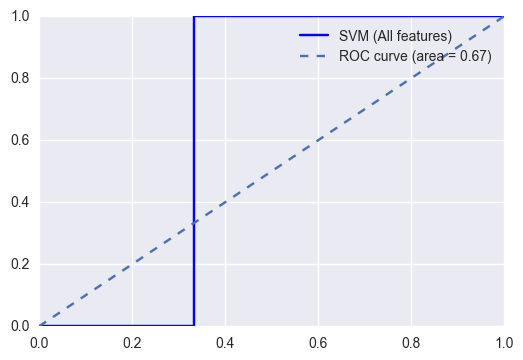

In [61]:
curva_roc([1]*3 + [0]*3, results, "SVM (All features)")

Se implemento un clasificador basado en Support Vector Machine al cuál se entrenó en una única ocasión con 24 features y 14 sujetos. El area bajo la curva ROC fue de 0.67.

## Pipeline (encapsulado como función)

Para hacer el análisis de los resultados mediante un Pipeline, implementamos una función que toma 2 parámetros. Cantidad de instancias por grupo que se utilizará para entrenamiento y la cantidad de features que seleccionará kBest. De esta manera, podemos hacer distintas pruebas para fijar una cantidad de instancias de entrenamiento razonable, y luego hacer el análisis variando el parámetro k

In [65]:
# La función recibe como parámetro la cantidad de instancias (por grupo) que desea usarase para entrenamiento.
# Por ejemplo, si n_training_instances = 1, se usa para entrenar 1 sujeto de cada grupo.
# Adicionalmente recibe la cantidad de features que selecciona kBest.

In [592]:
def evaluate_pipeline(n_training_instances, k=1):
    total = 10
    n_test_instances = total - n_training_instances
    training_labels = [1] * n_training_instances + [0] * n_training_instances
    test_labels = [1] * n_test_instances + [0] * n_test_instances
    
    s_instances = all_instances[0:n_training_instances,:]
    p_instances = all_instances[total:total+n_training_instances,:]
    training_instances = np.vstack((s_instances,p_instances))
    
    test_instances = np.vstack((all_instances[n_training_instances:total,:], all_instances[total + n_training_instances:2*total, :]))
    
    print "Entrenado con: " + str(training_instances.shape[0]/2) + " instancias de cada clase"
    print "Testeado con: " + str(test_instances.shape[0]/2) + " instancias de cada clase"
    
    scaler = StandardScaler()
    select_k_best = SelectKBest(f_regression, k=k).fit(training_instances, training_labels)
    indice_del_mejor = np.argmax(select_k_best.scores_)
    print "Feature que mejor separa: " + str(referencias_all_instances[indice_del_mejor])
    svm_model = svm.SVC(kernel='linear', probability=True)
    scaler_kBest_svm = Pipeline([('scaler', scaler), ('k_Best', select_k_best), ('svm', svm_model)])
    
    res = scaler_kBest_svm.fit(training_instances, training_labels).predict_proba(test_instances)
    title = "Trained with: " + str(n_training_instances * 2) + " instances, k= " + str(k) + " features selected"
    curva_roc(test_labels, res[:,1], title)
    

Ejemplos 1: Entrenado con 2 instancias de cada clase, k=1 (El mejor feature)

Entrenado con: 2 instancias de cada clase
Testeado con: 8 instancias de cada clase
Feature que mejor separa: mean_BETA


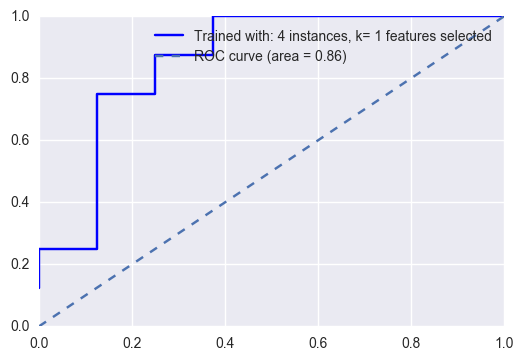

In [598]:
evaluate_pipeline(2, 1)

Ejemplos 2: Entrenado con 3 instancias de cada clase, k=2

Entrenado con: 3 instancias de cada clase
Testeado con: 7 instancias de cada clase
Feature que mejor separa: std_normalizado_ALPHA


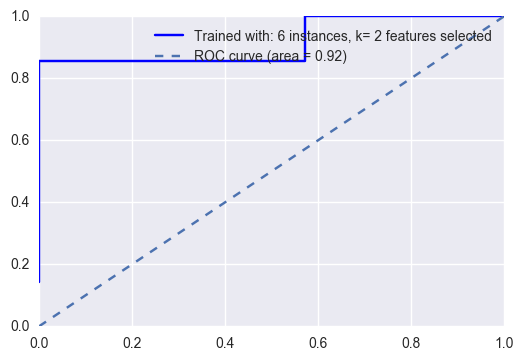

In [606]:
evaluate_pipeline(3, 2)

Ejemplos 3: Entrenado con 4 instancias de cada clase, k=3

Entrenado con: 4 instancias de cada clase
Testeado con: 6 instancias de cada clase
Feature que mejor separa: std_normalizado_ALPHA


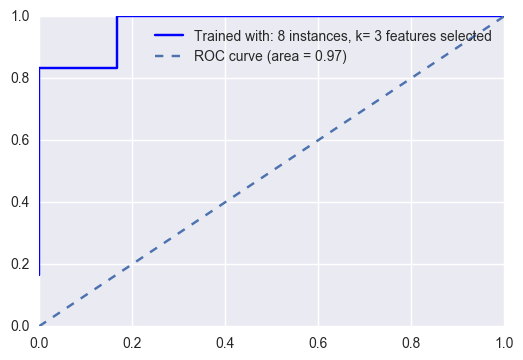

In [614]:
evaluate_pipeline(4, 3) #Evaluando con el 10% de los features (K=2)

Como puede observarse, la performance del clasificador aumenta a medida que utilizamos mayor cantidad de instancias de entrenamiento. Por este motivo, fijamos como número razonable 8 instancias de entrenamiento (por clase), quedando 4 instancias para testeo. Procedemos entonces a analizar las diferencias utilizando k=2, 5 y 8 (10%, 20% y 35% del total de los features respectivamente)

Entrenado con: 8 instancias de cada clase
Testeado con: 2 instancias de cada clase
Feature que mejor separa: std_ALPHA


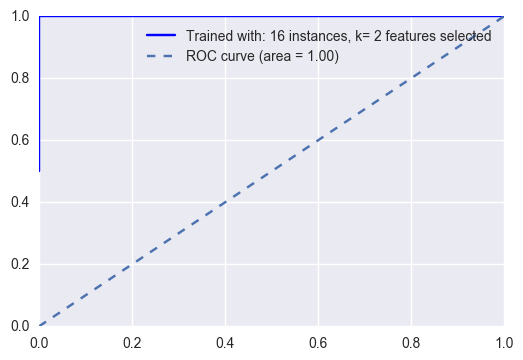

In [616]:
evaluate_pipeline(8, 2)

Entrenado con: 8 instancias de cada clase
Testeado con: 2 instancias de cada clase
Feature que mejor separa: std_ALPHA


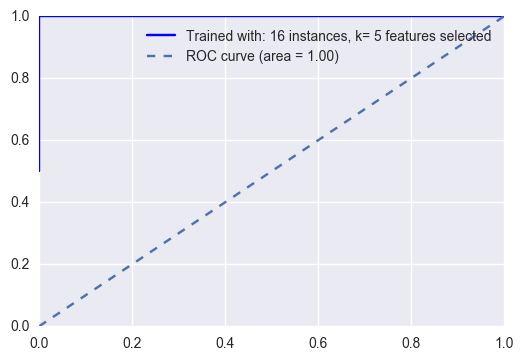

In [617]:
evaluate_pipeline(8, 5)

Entrenado con: 8 instancias de cada clase
Testeado con: 2 instancias de cada clase
Feature que mejor separa: std_ALPHA


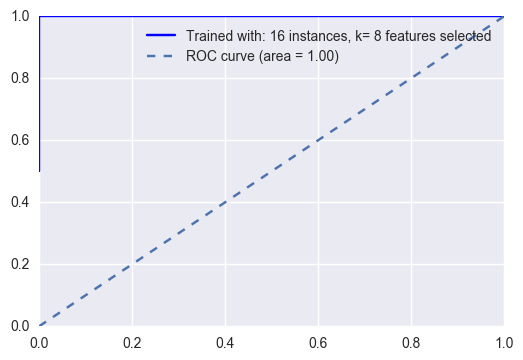

In [618]:
evaluate_pipeline(8, 8)

Analizando los resultados, obtenemos que sin importar el k seleccionado: 10%, 20% o 35% del total de los features, el SVM logra separar perfectamente las instancias de testing. Una explicación posible para este hecho se basa en que el feature que mejor separa es std_ALPHA, que ya habíamos visto en durante el análisis multivariado que lograba separar perfectamente entre las instancias

Se seleccionó para el método de k_best la función f_regression dado que:

In [64]:
f_regression(all_instances.T, labels)[1] # Realiza un especie de ANOVA y evalua cuál de todos los features es mejor predictor 
                                       # de los labels. Devuelve F y p-value de cada feature

array([  1.42396122e-03,   7.58506420e-01,   3.91018034e-04,
         1.60515580e-01,   3.11897008e-01,   8.22057088e-06,
         6.34649016e-01,   1.53785642e-05,   8.48093181e-04,
         8.49669607e-02,   6.05746975e-03,   5.79515280e-01,
         5.00835832e-04,   2.82424905e-01,   5.44350053e-01,
         8.96518786e-05,   1.61240331e-01,   8.76465758e-04,
         2.07563846e-02,   2.23696426e-01,   9.20143540e-02,
         1.76213751e-02,   4.81787516e-03,   5.01515023e-01])